<a href="https://colab.research.google.com/github/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Data_Collection_From_Twitter_with_Lexicon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install PySastrawi==1.2.0
!pip install snscrape==0.5.0.20230113
!pip install nltk==3.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Import some libraries

import pandas as pd
from datetime import timedelta, datetime
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import snscrape.modules.twitter as sntwitter

import datetime as dt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Created a list to append all tweet attributes(data)
attributes_container = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ikn lang:id').get_items()):  
    if i>50:
        break
    attributes_container.append([tweet.date, tweet.user.username,tweet.rawContent, tweet.sourceLabel])
    
# Creating a dataframe from the tweets list above 
tweets = pd.DataFrame(attributes_container, columns=["tweetcreatedts", "username", "tweet", "source"])
tweets.to_csv("tweet_data.csv")

In [20]:
tweets = pd.read_csv('tweet_data.csv')
tweets.sample(5)

,Unnamed: 0,tweetcreatedts,username,tweet,source
29,29,2023-03-03 01:21:07+00:00,taraticola,"Daripada pusing ASN pada gak mau pindah, mending utus saya aja Pak @jokowi untuk pindah ke IKN, ikhlas lahir batin ☺️☝️",Twitter for Android
11,11,2023-03-03 01:32:20+00:00,Yohanes_ARB,@garuda080 IKN Nusantara👍,Twitter for Android
10,10,2023-03-03 01:33:14+00:00,wonggemblung_,@geloraco Syarat calon presiden skrng sdh bukan WNI asli lagi ya???\n\nTapi syaratnya yg harus melanjutkaN IKN.,Twitter for Android
22,22,2023-03-03 01:22:44+00:00,adebenzain1,@Miduk17 IKN tetap di lanjutkan anies kok,Twitter Web App
2,2,2023-03-03 01:37:53+00:00,AmrullahMap,Ikn Saranjanan? ...Tonton dan unduh video menarik secara gratis di Mi Video:https://t.co/4Zy64B4s6O,Twitter for Android


In [21]:
# Some functions for preprocessing text
def cleaningText(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # remove mentions
    tweet = re.sub(r'#[A-Za-z0-9]+', '', tweet) # remove hashtag
    tweet = re.sub(r'RT[\s]', '', tweet) # remove RT
    tweet = re.sub(r"http\S+", '', tweet) # remove link
    tweet = re.sub(r'[0-9]+', '', tweet) # remove numbers
    tweet = tweet.replace('\n', ' ') # replace new line into space
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    tweet = tweet.strip(' ') # remove characters space from both left and right text
    return tweet

def casefoldingText(tweet): # Converting all the characters in a text into lower case
    tweet = tweet.lower() 
    return tweet

key_norm = pd.read_csv('https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/kamus-slang-ind.csv', encoding='ISO-8859-1')
def text_normalize(tweet):
    tweet = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in tweet.split()
    ])
    return tweet

def tokenizingText(tweet): # Tokenizing or splitting a string, text into a list of tokens
    tweet = word_tokenize(tweet) 
    return tweet

def filteringText(tweet): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in tweet:
        if txt not in listStopwords:
            filtered.append(txt)
    tweet = filtered 
    return tweet

def stemmingText(tweet): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tweet = [stemmer.stem(word) for word in tweet]
    return tweet

In [22]:
# Preprocessing tweets data
tweets['text_clean'] = tweets['tweet'].apply(cleaningText)
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)
tweets['text_clean'] = tweets['text_clean'].apply(text_normalize)
tweets.drop(['tweet'], axis = 1, inplace = True)

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)
tweets.drop_duplicates(subset = 'text_clean', inplace = True)

In [23]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)
lexicon_positive = {}
positive = 'https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/lexicon_positive.csv'
positive  = pd.read_csv(positive )
for index, row in positive.iterrows():
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = {}
negative = 'https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/lexicon_negative.csv'
negative  = pd.read_csv(negative )
for index, row in negative.iterrows():
    lexicon_negative[row[0]] = int(row[1])
               
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positif'
    elif (score < 0):
        polarity = 'negatif'
    else:
        polarity = 'positif' # dapat diganti dengan netral
    return score, polarity

In [24]:
# Results from determine sentiment polarity of tweets
results = tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['polarity_score'] = results[0]
tweets['polarity'] = results[1]

In [25]:
print(tweets['polarity'].value_counts())

positif    28
negatif    23
Name: polarity, dtype: int64


In [26]:
# Export to csv file
tweets.to_excel(r'tweets_data_clean_with_polarity.xlsx', index = False, header = True, index_label=None)
tweets.sample(10)

,Unnamed: 0,tweetcreatedts,username,source,text_clean,text_preprocessed,polarity_score,polarity
2,2,2023-03-03 01:37:53+00:00,AmrullahMap,Twitter for Android,ikn saranjanan tonton dan unduh video menarik secara gratis di mi video,"[ikn, saranjanan, tonton, unduh, video, tarik, gratis, mi, video]",2,positif
30,30,2023-03-03 01:18:12+00:00,Bank_Aconk,Twitter for Android,bangun ikn nusantara kementerian pekerjaan umum dan perumahan rakyat siapkan strategi pelaksanaan dan manajemen risiko menteri pekerjaan umum dan perumahan rakyat basuki hadimuljono prinsip tata kelola pembangunan di ikn harus tepat waktu tepat mutu tepat biaya tepat manfaat sasaran tepat administrasi dan tepat kuantitas,"[bangun, ikn, nusantara, menteri, kerja, rumah, rakyat, siap, strategi, laksana, manajemen, risiko, menteri, kerja, rumah, rakyat, basuki, hadimuljono, prinsip, tata, kelola, bangun, ikn, mutu, biaya, manfaat, sasar, administrasi, kuantitas]",6,positif
23,23,2023-03-03 01:22:30+00:00,Almudattsir,Twitter for Android,mungkin jeep tersebut buat inpeksi jalan yang kena banjir atau mau off road ke kalimantan sekalian lihat ikn masak gubernur tidak boleh pakai jeep😏 sedangkan anak pejabat boleh saja padahal sumbernja juga tidak jelas😀 gubernur sebelumnja cuma pakai kijang innova bersantai saja tidak perlu gagahan,"[jeep, inpeksi, jalan, kena, banjir, off, road, kalimantan, lihat, ikn, masak, gubernur, pakai, jeep, anak, jabat, sumbernja, jelas, gubernur, sebelumnja, pakai, kijang, innova, santa, gagah]",-1,negatif
16,16,2023-03-03 01:29:12+00:00,Akomeng6,Twitter for Android,dukung ikn,"[dukung, ikn]",4,positif
13,13,2023-03-03 01:31:02+00:00,Akomeng6,Twitter for Android,ikn jos🇮🇩👆👍,"[ikn, jos]",0,positif
28,28,2023-03-03 01:21:12+00:00,andyydepp,Twitter for Android,secara logika memang ikn harus dibatalkan mengingat kondisi keuangan negara yang tidak memungkinkan tetapi mekanisme pembatalannya harus melalui dewan perwakilan rakyat kalau partai yang tidak setuju ikn cuma sedikit dapat kursi ya pasti kalah suara di dewan perwakilan rakyat,"[logika, ikn, batal, kondisi, uang, negara, mekanisme, batal, dewan, wakil, rakyat, partai, tuju, ikn, kursi, ya, kalah, suara, dewan, wakil, rakyat]",-20,negatif
9,9,2023-03-03 01:33:24+00:00,Yohanes_ARB,Twitter for Android,aconk luar biasa ikn,"[aconk, ikn]",0,positif
46,46,2023-03-03 01:04:00+00:00,RadarKorupsi,Twitter for iPhone,asyeek…dari pada jadi tenaga kerja Idonesia lebih baik jadi aasn di ikn memang benar canggih itu halunya semua yang di ikn,"[asyeek dari, tenaga, kerja, idonesia, aasn, ikn, canggih, halunya, ikn]",3,positif
33,33,2023-03-03 01:17:06+00:00,SatuhatiCoffee,Twitter Web App,kita urut reklamasi tidak jadi cuan amp bani cebong harus tanggung t lebih uang yang masuk ahok kalah pula gasak pakai plandemik t lebih untuk ganti gagal cuan reklamasi tidak hasil juga dan skema berantakan saat ini ikn proyek berharap sebagai ganti rugi gagal cuan,"[urut, reklamasi, cuan, amp, bani, cebong, tanggung, t, uang, masuk, ahok, kalah, gasak, pakai, plandemik, t, ganti, gagal, cuan, reklamasi, hasil, skema, beranta, ikn, proyek, harap, ganti, rugi, gagal, cuan]",-21,negatif
37,37,2023-03-03 01:13:53+00:00,heavenmas,Twitter for Android,saya juga ingin anjir selesai si di tarik buat ngerancang interiorspace plane ikn siapa yang tidak mau anjir duit itu duit sekaligus pulang kampung 😭,"[anjir, selesai, si, tarik, ngerancang, interiorspace, plane, ikn, anjir, duit, duit, pulang, kampung, ]",0,positif


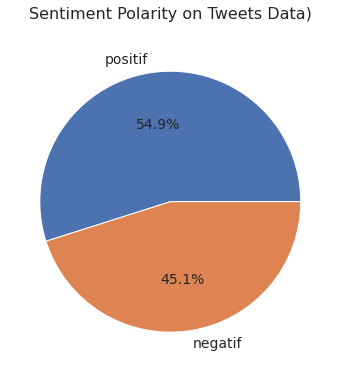

In [27]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['polarity'].value_counts()]
labels = list(tweets['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data)', fontsize = 16, pad = 20)
plt.show()

In [28]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positif']
positive_tweets = positive_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_clean,polarity_score,polarity
1,dukung pembangunan ikn nusantara menurut presiden proyek pembangunan ikn bukanlah proyek jangka pendek dan akan memakan waktu pembangunan hingga tahun mendatang meski demikian presiden menegaskan bahwa pembangunan infrastruktur ikn sudah mulai dikerjakan di lapangan,15,positif
2,mas ayo di ikn naik speed boat sing tanpa roof cabin ikut teko pelabuhan semayang sekaligus uji nyali 🤣,14,positif
3,dana bohir yang mengalir kepada anies nampaknya cukup deras dan kuat terbukti dengan adanya perubahan sikap dari menolak menjadi mendukung ikn gavi vini indomie yatai komisi perlindungan anak indonesia matthew jenna jenna artist and staf jangan lie nmixx sirens calling partai prima park jimin nomor,12,positif
4,jokowi ikn dapat berjalan dengan lancar dan sesuai jadwal menurut dia rasa optimisme itu berdasar pengalaman pemerintah membangun sejumlah infrastruktur di indonesia memang di luar nalar tapi itulah pakde jokowi yang selalu optimis dan percaya kepada menteri pekerjaan umum dan perumahan rakyat pak basuki👍,8,positif
5,dukung optimisme pemerintah untuk menyelesaikan ikn dalam tahun kita semua tahu kan kalau proyek pembangunan ikn bukanlah proyek jangka pendek dan akan memakan waktu pembangunan hingga tahun mendatang ya lanjutkannnn🇮🇩💪,8,positif
6,presiden jokowi ingin pembangunan ikn nusantara berjalan baik dan lancar untuk itu kementerian pekerjaan umum dan perumahan rakyat menyiapkan strategi jitu dimana prinsip tata kelola pembangunan di ikn harus tepat waktu tepat mutu tepat biaya tepat manfaatsasaran tepat administrasi dan tepat kuantitas,8,positif
7,jadi dulu presiden terus ubah undang undang ikn karena tidak ada dana dan tidak darurat,8,positif
8,bangun ikn nusantara kementerian pekerjaan umum dan perumahan rakyat siapkan strategi pelaksanaan dan manajemen risiko menteri pekerjaan umum dan perumahan rakyat basuki hadimuljono prinsip tata kelola pembangunan di ikn harus tepat waktu tepat mutu tepat biaya tepat manfaat sasaran tepat administrasi dan tepat kuantitas,6,positif
9,aconk dukung ikn,4,positif
10,ikn nusantara di dukung semua elemen masyarakat,4,positif


In [29]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negatif']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,kita urut reklamasi tidak jadi cuan amp bani cebong harus tanggung t lebih uang yang masuk ahok kalah pula gasak pakai plandemik t lebih untuk ganti gagal cuan reklamasi tidak hasil juga dan skema berantakan saat ini ikn proyek berharap sebagai ganti rugi gagal cuan,-21,negatif
2,secara logika memang ikn harus dibatalkan mengingat kondisi keuangan negara yang tidak memungkinkan tetapi mekanisme pembatalannya harus melalui dewan perwakilan rakyat kalau partai yang tidak setuju ikn cuma sedikit dapat kursi ya pasti kalah suara di dewan perwakilan rakyat,-20,negatif
3,negatif thinking akan membuat orang berpikiran sempit ada yang bilang buat apa infrastruktur rakyat tidak butuh rakyat butuh makan buat apa ikn padahal kalau sudah jadi mereka juga akan merasakan manfaatnya tapi begitulah sempitnya pikiran mereka,-17,negatif
4,saewad partai demokrasi indonesia perjuangan takut anise akan menegakkan hukum maka partai demokrasi indonesia perjuangan akan bangkrut anise pasti tidak akan menumpuk hutang karena sudah tidak mungkin lagi maka ikn akan jadi hambalang partai demokrasi indonesia perjuangan karma pasti berlaku,-17,negatif
5,lo kok mirip sama tug boat ya eh salah lihat perahu speed yang bawah jumlahnya saya tandain dulu ah tempatnya berarti ini nyusur teluk balikpapan kalau jalurnya ikn,-12,negatif
6,komisi pemelihan umum sengaja mengalah karena untuk kepentingan ikn ujungnya jabatan komisaris menunggu,-11,negatif
7,maksud dan tujuan ikn sudah sangat jelas 👉 indonesia sentris demi kemajuan 🇮🇩👍 dan rasakan bedanya bedakan rasanya tiada tanding tiada banding jokowi dihati ganjar dinanti 👍👍🇲🇨🇲🇨🇲🇨🇲🇨🇲🇨💪💪,-11,negatif
8,terancam gagal ikn bukan gagasan saya tunda pemilihan umum bukan gagasan saya yang nanti di klaim gagasannya sumur resapan sama formula e,-10,negatif
9,saewad ringkasnya saja jawaban nya beragam usaha bagi masyarakat kalimantan di sekitar ikn masyarakat sekitar ikn tetap bisa bekerja tanpa terganggu demo demo tidak penting,-10,negatif
10,dek sabar ya pakde lagi memikirkan ikn yang sebentar lagi mau gunting pita kan sudah banyak gedung bertingkat jalanny bisa ngecas baterai moblis buat stadion sepak bola kelas dunia hmmapa lagi ya 🤣🤣🤣🤣🤣,-8,negatif


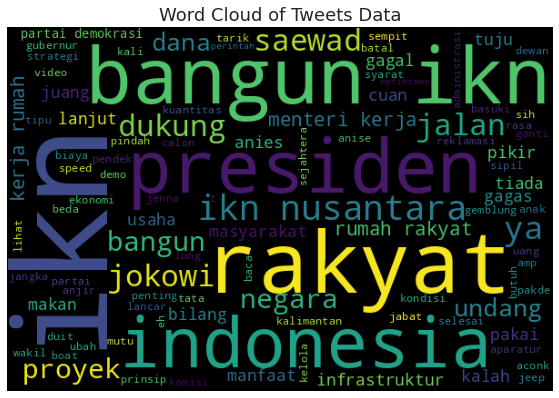

In [30]:
# Visualize word cloud
list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [31]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

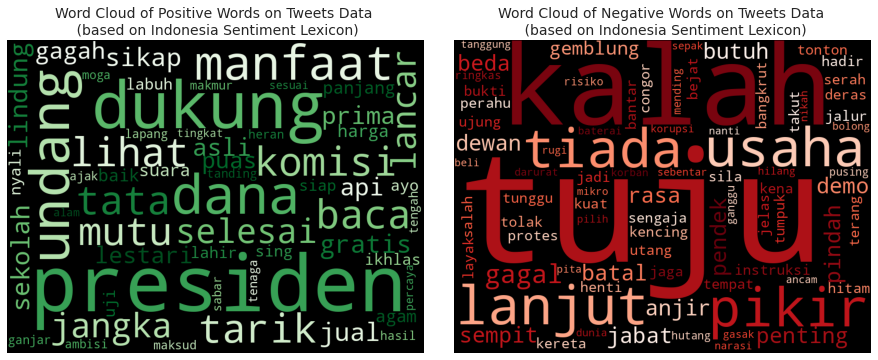

In [32]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()